 # Attenuation (logaritmo della media delle ampiezze)
 

In [12]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info.operators import Operator
from qiskit import execute, transpile, assemble
from qiskit import Aer
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_histogram
from sympy import factorint
from fractions import Fraction
from numpy import linalg
import pandas as pd
import numpy as np
from numpy import pi
from sympy import *
import random
import math
import pickle
import qiskit.quantum_info as qi
from qiskit.visualization import array_to_latex
from qiskit.providers.aer.library import SaveDensityMatrix

from qiskit.quantum_info import Statevector

In [13]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

In [14]:
def qft_rotations(circuit, n, n_max,  case, position):
    tmp = n_max - case
    
    if n == 0:
        return circuit
    n -= 1    

    if n  == tmp:
        errori(circuit, position, n)  
    
    circuit.h(n)   
    
    for qubit in range(n):
        circuit.cp(np.pi/2**(n-qubit), qubit, n)

    qft_rotations(circuit, n, n_max, case, position)

In [15]:
def swap_registers(circuit, n):
    
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)

In [16]:
def errori(circuit, position, n):
    epsilon = 0.5                                #probability p of x error, 1-p prob. of z error                         
    extracted = random.uniform(0, 1)
    
    if (extracted < epsilon):    
        circuit.x(position)   
        #flag = 0
        circuit.barrier(range(n))
    else:
        circuit.z(position)
        #flag = 1
        circuit.barrier(range(n))
    return circuit

In [17]:
def qft(circuit, n, n_max, case, position):
    if case == 1:
        errori(circuit, position, n) 

    qft_rotations(circuit, n, n_max, case, position)

    if case == n + 1:
        errori(circuit, position, n)
    
    swap_registers(circuit, n)    

    if case == n + 2:
        errori(circuit, position , n)
        
    if case == 0:
        pass
        
    if case > n + 2:
        print('Error: case value incorrect')
    return circuit

In [18]:
def split_circuit_by_barrier(circuit):
    qasm = circuit.qasm()
    prelude = []
    circuits = [[]]
    for line in qasm.splitlines():
        if any([line.startswith(t) for t in ['OPENQASM', 'include', 'qreg', 'creg']]):
            prelude.append(line)
        elif line.startswith('barrier'):
            break
            circuits.append([])
        else:
            circuits[-1].append(line)
    circuits_with_prelude = [prelude+circuit for circuit in circuits]
    for circuit_with_prelude in circuits_with_prelude:
        yield QuantumCircuit.from_qasm_str('\n'.join(circuit_with_prelude))

In [19]:
def split_circuit_by_error(circuit):
    qasm = circuit.qasm()
    prelude = []
    circuits = [[]]
    
    for line in qasm.splitlines():
        if any([line.startswith(t) for t in ['OPENQASM', 'include', 'qreg', 'creg']]):
            prelude.append(line)
        elif line.startswith('z'):
            break
        elif line.startswith('x'):
            break
            circuits.append([])
        else:
            circuits[-1].append(line)
    circuits_with_prelude = [prelude+circuit for circuit in circuits]
    for circuit_with_prelude in circuits_with_prelude:
        yield QuantumCircuit.from_qasm_str('\n'.join(circuit_with_prelude))


Main:
- Fixed max number of qubits (qubits);

In [20]:
qubits = 8
repetitions = 10

matrix = []

for n in range(1, qubits + 1):
    amplitudes = np.empty(n + 3)
    x = []
    
    for case in range(n + 3):
        summa = 0
        
        for reps in range(repetitions):
            position = random.randint(0, n - 1)

            control = QuantumRegister(n, 'r1')
            circuit = QuantumCircuit(control)

            qft(circuit, n, n, case, position) 

            for subcircuit in (split_circuit_by_barrier(circuit)):
                circuit_right = subcircuit

            for subcircuit in (split_circuit_by_error(circuit)):
                circuit_left = subcircuit

            circuit_right = circuit_right.inverse()
            merge = circuit_left.compose(circuit_right)

            backend = Aer.get_backend('unitary_simulator')
            job = execute(merge, backend, shots = 4096)
            result = job.result()
            UeU = result.get_unitary(merge,3)

            for i in range(2**n):   

                label = bin(i).lstrip('-0b').zfill(n)
                if case == 0:
                    x.append(label)

                state = Statevector.from_label(label)
                summa = summa + (state.evolve(UeU)[label]**2).real
                i += 1
                state = 0

            merge = 0
            result = 0
            UeU = 0

        amplitudes[case] = summa
        reps += 1
        
    for ii in range(0, n + 3):
        amplitudes[ii] = - math.log(amplitudes[ii], 2) / n*reps*(2**n)
    n += 1
    matrix.append(amplitudes)

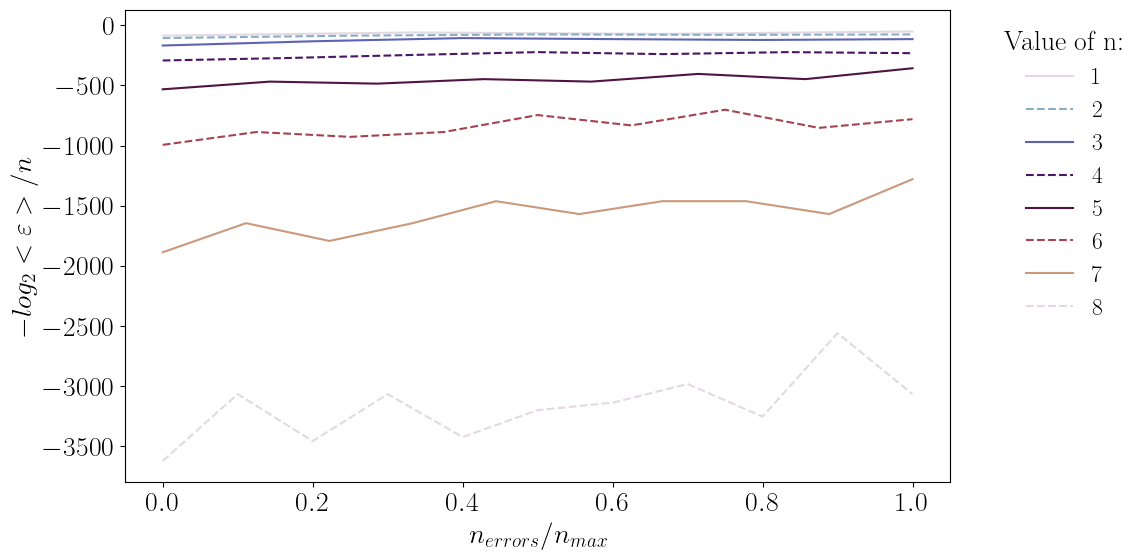

In [21]:
params = {'text.usetex' : True, 'font.size' : 20, 'font.family' : 'serif'}
plt.rcParams.update(params)
xs = []
for n in range(1, qubits + 1):
    lista = []
    for i in range(n + 3):
        lista.append(i/ (n + 2))
    xs.append(lista)
    
labels = [1,2,3,4,5,6,7,8]
cmap = plt.get_cmap('twilight')

plt.figure()
for i in range(qubits):
    label = labels[i] 
    color = cmap( i/(qubits-1))  
    if i%2 == 1:
        plt.plot(xs[i], matrix[i], label=f'{label}', color=color, linestyle = 'dashed')
    else: 
        plt.plot(xs[i], matrix[i], label=f'{label}', color=color)

plt.xlabel(r"${n_{errors}}/{n_{max}}$")
plt.ylabel(r"$- {log_2 <\varepsilon>/ n }$", rotation = 90)
plt.tight_layout()
plt.legend(fontsize=17, frameon=False,bbox_to_anchor=(1.04, 1), title = 'Value of n:')
plt.savefig('attenuationBIS.pdf', format = 'pdf') 
pickle.dump(matrix, open('attenuationBIS.pkl', 'wb'))